In [1]:
import numpy as np
import aipy as a
from hera_cal import omni
import hera_qm.ant_metrics as ant_metrics
reload(ant_metrics)
from hera_cal.data import DATA_PATH
import sys

# Setup

In [2]:
verbose = True
pols = ['xx','xy','yx','yy']
JD = '2457757.47316'
#dataFileList = ['/data4/paper/HERA2015/'+JD.split('.')[0]+'/zen.'+JD+'.'+pol+'.HH.uvc' for pol in pols]
#dataFileList = ['../../HERA2015Data/'+JD.split('.')[0]+'/zen.'+JD+'.'+pol+'.HH.uvc' for pol in pols]
dataFileList = [DATA_PATH + '/zen.2457698.40355.xx.HH.uvcA',
                DATA_PATH + '/zen.2457698.40355.xy.HH.uvcA',
                DATA_PATH + '/zen.2457698.40355.yx.HH.uvcA',
                DATA_PATH + '/zen.2457698.40355.yy.HH.uvcA']

freqs = np.arange(.1,.2,.1/1024)
sys.path.append(DATA_PATH)
aa = a.cal.get_aa('heratest_calfile', freqs)
info = omni.aa_to_info(aa, pols=[pols[-1][0]], crosspols=[pols[-1]])
reds = info.get_reds()
metricsJSONFilename = JD+'.metrics.json'

# Main script for computing and saving metrics

In [3]:
am = ant_metrics.Antenna_Metrics(dataFileList, reds, fileformat='miriad')
am.iterative_antenna_metrics_and_flagging(crossCut=5, deadCut=5, verbose=verbose)
am.save_antenna_metrics(metricsJSONFilename)

Combined polarizations are not evenly spaced. This will make it impossible to write this data out to some file types.


On iteration 0 we flag (81, 'x')
On iteration 1 we flag (81, 'y')


In [4]:
# #pyuvdata:
# %timeit -n 100 am.uvdata.get_data(65,81,'xx'); #forwards
# %timeit -n 100 am.uvdata.get_data(81,65,'xx'); #backwards
# %timeit -n 100 am.uvdata.get_data(65,81);

# #DataContainer:
# %timeit -n 100 am.data.get_data(65,81,'xx'); #forwards
# %timeit -n 100 am.data.get_data(81,65,'xx'); #backwards

# %load_ext line_profiler
# %lprun -f am.uvdata.get_data am.uvdata.get_data(65,81,'xx')

# Plotting

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_metric(metrics, ants=None, antpols=None, title='', ylabel='Modified z-Score', xlabel=''):
    '''Helper function for quickly plotting an individual antenna metric.'''

    if ants is None:
        ants = list(set([key[0] for key in metrics.keys()]))
    if antpols is None:
        antpols = list(set([key[1] for key in metrics.keys()]))

    for antpol in antpols:
        for i,ant in enumerate(ants):
            metric = 0
            if metrics.has_key((ant,antpol)):
                metric = metrics[(ant,antpol)]
            plt.plot(i,metric,'.')
            plt.annotate(str(ant)+antpol,xy=(i,metrics[(ant,antpol)]))
        plt.gca().set_prop_cycle(None)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)

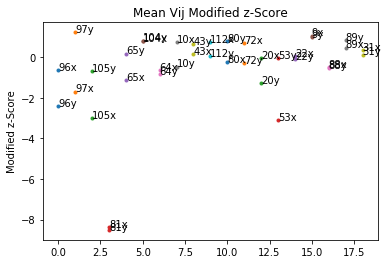

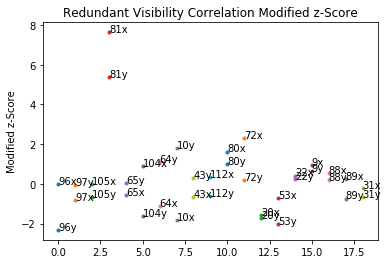

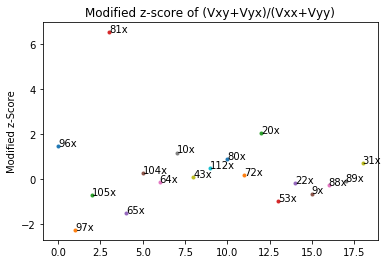

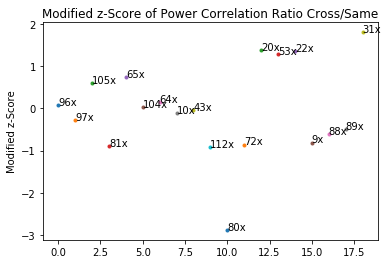

In [6]:
metrics_results = ant_metrics.load_antenna_metrics(metricsJSONFilename)

plt.figure()
plot_metric(metrics_results['final_mod_z_scores']['meanVij'], 
            title = 'Mean Vij Modified z-Score')

plt.figure()
plot_metric(metrics_results['final_mod_z_scores']['redCorr'],
            title = 'Redundant Visibility Correlation Modified z-Score')

plt.figure()
plot_metric(metrics_results['final_mod_z_scores']['meanVijXPol'], antpols=['x'],
            title = 'Modified z-score of (Vxy+Vyx)/(Vxx+Vyy)')

plt.figure()
plot_metric(metrics_results['final_mod_z_scores']['redCorrXPol'], antpols=['x'],
            title = 'Modified z-Score of Power Correlation Ratio Cross/Same')